# Create a file with Observation times

We are going to create a file that contains the observation times and the passbands in which this happens. This notebook is only useful if this happens in regular intervals and regular order. One can always edit the output file manually.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astroplan import Observer

Let's first define the center of our observations and the size of the aperture

In [2]:
RA_center =  "14:00.00"            #In hh:mm:ss
DEC_center = "20:00.00"            #In DD:mm:ss
RA_aperture = 3.0                  #Degrees
DEC_aperture = 3.0                 #Degrees

What's the location where to observe from?

In [3]:
LocationName = 'Palomar'
Location     =  EarthLocation.of_site(LocationName)
Olson_tz     = 'America/Los_Angeles'              #From 'TZ': https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
#One can also define the location yourself
#Location = EarthLocation(lat=-29.257409*u.deg, lon=-70.737954*u.deg, height=2400*u.m)

Now you need to fill in some observational information

In [4]:
Filename             = '../Obstimes.dat'         #The output file
First_obs            = '2018-07-03T23:55:00.123456789' #In yyyy-mm-ddThh:mm:ss
Passbands            = ['u', 'g', 'r', 'i']           #The passbands in the observing order
Lowest_altitude      = 30                        #The limiting altitude for observations in degrees (due to airmass/obstacles etc.)
Nights               = [0,1,2,3,4,5]             #List of nights on which to observe. Can also be a numpy.linspace array.
Max_nr_obs_per_night = 4                         #Maximum numer of observation cycles per night
Filtertime           = 1 * u.min                 #Time between observations of two filters
Cadence              = 1 * u.hour                #Time between two consecutive observations in the same night in the same filter
Immediate            = True                      #Observe immediately after sunset on the 2nd,3rd,4th,... nights
Sun_below_horizon    = -6                        #[-6, -12, -18] in degrees. How many degrees the Sun needs to be below the horizon to observe

Convert the amount of degrees the Sun should be below the horizon to an evening type that astroplan.Observer understands

In [5]:
Observatory = Observer(location=Location, name=LocationName, timezone=Olson_tz)
if Sun_below_horizon == -6:
    twilight_evening = Observatory.twilight_evening_civil
    twilight_morning = Observatory.twilight_morning_civil
elif Sun_below_horizon == -12:
    twilight_evening = Observatory.twilight_evening_nautical
    twilight_morning = Observatory.twilight_morning_nautical
elif Sun_below_horizon == -18:
    twilight_evening = Observatory.twilight_evening_astronomical
    twilight_morning = Observatory.twilight_morning_astronomical
else:
    print "please enter a correct answer at the Sun_below_horizon parameter above. Choose from [-6, -12, -18]"

Let's generate an array with times in Julian Date

In [6]:
Coords_c = SkyCoord(RA_center + ' ' + DEC_center, unit=(u.hourangle, u.deg))
time = Time(First_obs, format='isot', scale='utc')
Times = np.linspace(time.jd, time.jd + Nights[-1]+1, 1000 * Nights[-1])
Times_utc = Time(Times, format='jd', scale='utc')
Times_isot = Times_utc.isot

And a list with times when the night starts and ends

In [7]:
Night_starts = []
Night_ends = []

Night = twilight_evening(time =Times_utc[0], which='nearest')
if Times[0] > Night.jd:
    Night = Times_utc[0]
Night_starts.append(Night.jd)
Morning = twilight_morning(time =Times_utc[0], which='next')
Night_ends.append(Morning.jd)

while Night.jd < Times[-1] and Morning.jd < Times[-1]:
    Night   = twilight_evening(time =Night, which='next')
    Morning = twilight_morning(time =Night, which='next')
    Night_starts.append(Night.jd)
    Night_ends.append(Morning.jd)

Now we're going to select the times when one can observe the patch in the sky given its position on the sky at the observatory. This is stored in the array 'Possible'

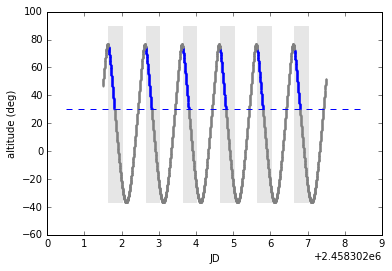

In [8]:
Altitudes = Coords_c.transform_to(AltAz(obstime=Times_isot, location=Location)).alt.deg

Bool1 = np.array(Altitudes > Lowest_altitude)
Bool2 = np.zeros(len(Bool1), dtype = bool)
for i in range(len(Night_ends)):
    Bool2 = Bool2 + np.array(Times < Night_ends[i]) *  np.array(Times > Night_starts[i])
Possible =  Bool1 * Bool2    #When is it possible to observe this patch?

if len(Possible) == 0: print "These coordinates are not observable during these nights!!!!"

#Interpol = interp1d(Times, Altitudes)


plt.scatter(Times[Possible], Altitudes[Possible], s=1, color = 'b')
plt.scatter(Times[~Possible], Altitudes[~Possible], s=1, color = 'grey')
plt.plot([Times[0]-1, Times[-1]+1], [Lowest_altitude, Lowest_altitude], '--')
for i in range(len(Night_ends)):
    Boolean =  np.array(Times < Night_ends[i]) *  np.array(Times > Night_starts[i])
    plt.fill_between(Times, min(Altitudes), 90,
                 Boolean, color='0.9', zorder=0)

plt.xlabel('JD')
plt.ylabel('altitude (deg)')
plt.show()

We'll define two functions to know what the first and last moments are on which one can observe in a certain night

In [9]:
def FirstPossibleObs(Nightnr):
    This_night_start = Night_starts[Nightnr]
    Time_TNS = Time(This_night_start, format='jd', scale='utc')
    Rise_time = Observatory.target_rise_time(Time_TNS, Coords_c, which='nearest', horizon = Lowest_altitude * u.deg)
    return max(This_night_start, Rise_time.jd)


def LastPossibleObs(Nightnr):
    This_night_end = Night_ends[Nightnr]
    This_night_start = Night_starts[Nightnr]
    Time_TNS = Time(This_night_start, format='jd', scale='utc')
    Rise_time = Observatory.target_rise_time(Time_TNS, Coords_c, which='nearest', horizon = Lowest_altitude * u.deg)
    Set_time = Observatory.target_set_time(Rise_time, Coords_c, which='next', horizon = Lowest_altitude * u.deg)
    return min(Set_time.jd, This_night_end)

We need a function that simply checks whether our coordinates are well observable at a given time

In [10]:
def Observable(TIME, Nightnr):
    First = FirstPossibleObs(Nightnr)
    Last  = LastPossibleObs(Nightnr)
    return TIME >= First and TIME <= Last

Let's now generate a list with our observation times. We will start at the first possible observation time.  We will try to add as many observations on that night as possible, but taking the maximum number of observations per night into account. The next night observations start at either when the field rises above minimum altitude (when Immediate==True), or at the same time on the night as the first observation.

In [11]:
Colors = Passbands
Ftime = Filtertime.to(u.day).value
NotFinished = True
NotObservable = True
Obslist  = []
Obscolor = []
NightNr = 0
Obs_this_night = 0

First = FirstPossibleObs(NightNr)
for i,C in enumerate(Colors):
    Otime = First + i * Ftime
    if Observable(Otime, NightNr):
        Obslist.append(Otime)
        Obscolor.append(C)
if len(Obslist) > 0: Obs_this_night +=1
        
NewTime = First
First_obs_this_night = First
while NightNr < len(Nights):
    print "Calculating observations for night ", Nights[NightNr]
    if Immediate:
        NewTime = FirstPossibleObs(NightNr)
    else:
        NewTime = First + Nights[NightNr]
    First_obs_this_night = NewTime
    while Obs_this_night < Max_nr_obs_per_night:
        NewTime += Cadence.to(u.day).value * Obs_this_night
        if NewTime > LastPossibleObs(NightNr): break
        Observed_this = False
        for i,C in enumerate(Colors):
            Otime = NewTime + i * Ftime
            if Observable(Otime, NightNr):
                Obslist.append(Otime)
                Obscolor.append(C)
                Observed_this = True
        if Observed_this: Obs_this_night +=1
        #else: NewTime = FirstPossibleObs(NightNr)         #Not visible at original observing time. Reverting to first possible time
    NightNr +=1
    Obs_this_night = 0

Calculating observations for night  0
Calculating observations for night  1
Calculating observations for night  2
Calculating observations for night  3
Calculating observations for night  4
Calculating observations for night  5


In [12]:
f = open(Filename, 'wb' )
cwr = csv.writer( f, delimiter = '\t' )
Loc = 'N %s E %s' % (str(Location.lat),str(Location.lon))
cwr.writerow([LocationName, Loc])
cwr.writerow(['JD', 'filter'])
cwr.writerows(np.array([Obslist,Obscolor]).T)
f.close()